In [2]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 36.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompat

**Extraction of Node2Vec embeddings**


In [3]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import numpy as np

# --- 1. LOAD BOTH TRAIN AND TEST EDGE FILES ---
train_pos_df = pd.read_csv('/kaggle/input/leakfree-edges/train_positives.csv')
test_pos_df = pd.read_csv('/kaggle/input/leakfree-edges/test_positives.csv')

print("First rows of train_positives.csv:")
print(train_pos_df.head())

# --- 2. GET ALL UNIQUE NODES FROM BOTH TRAIN AND TEST ---
train_nodes = set(train_pos_df['node_1']).union(set(train_pos_df['node_2']))
test_nodes = set(test_pos_df['node_1']).union(set(test_pos_df['node_2']))
all_nodes = train_nodes.union(test_nodes)

print(f"Nodes in train: {len(train_nodes)}")
print(f"Nodes in test: {len(test_nodes)}")
print(f"Total unique nodes: {len(all_nodes)}")
print(f"Nodes only in test (not in train): {len(test_nodes - train_nodes)}")

# --- 3. BUILD THE TRAINING GRAPH WITH ALL NODES ---
# Start with train edges only (no leakage)
G_train = nx.from_pandas_edgelist(train_pos_df, 'node_1', 'node_2')

# Add isolated nodes that appear in test but not in train
# These will be isolated in the training graph but will still get embeddings
isolated_nodes = test_nodes - train_nodes
G_train.add_nodes_from(isolated_nodes)

print(f"Training graph: {G_train.number_of_nodes()} nodes, {G_train.number_of_edges()} edges.")
print(f"Isolated nodes (appear only in test): {len(isolated_nodes)}")

# --- 4. GENERATE NODE2VEC EMBEDDINGS FOR ALL NODES ---
# Install node2vec if not present
try:
    from node2vec import Node2Vec
except ImportError:
    import sys
    !{sys.executable} -m pip install node2vec
    from node2vec import Node2Vec

# Fit Node2Vec
node2vec = Node2Vec(
    G_train,
    dimensions=64,      # Embedding size
    walk_length=30,
    num_walks=50,
    workers=4,
    seed=42,
)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

# --- 5. BUILD THE EMBEDDING MATRIX ---
# Map node ids to embeddings in a consistent order
node_list = list(G_train.nodes())
node_list_str = [str(n) for n in node_list]   # Node2Vec uses string ids internally

emb_matrix = np.array([model.wv[n] for n in node_list_str])
print(f"Embeddings matrix shape: {emb_matrix.shape}  (nodes x embedding_size)")

# Save embeddings
np.save("n2v_train_embeddings.npy", emb_matrix)

# Save as DataFrame with node ids for reference
emb_df = pd.DataFrame(emb_matrix, index=node_list)
emb_df.to_csv("n2v_train_embeddings.csv")
print("Saved embeddings to n2v_train_embeddings.csv")

# --- 6. VERIFY WE HAVE ALL NEEDED NODES ---
embedded_nodes = set(node_list)
missing_nodes = all_nodes - embedded_nodes

if len(missing_nodes) == 0:
    print("✅ SUCCESS: All nodes from train and test sets have embeddings!")
else:
    print(f"❌ WARNING: Missing embeddings for {len(missing_nodes)} nodes: {list(missing_nodes)[:10]}")

# --- 7. OPTIONAL: Check embedding for a specific node ---
example_node = node_list[0]
print(f"Embedding for node {example_node}:", emb_df.loc[example_node].values[:5], "...")

# --- 8. CREATE NODE-TO-INDEX MAPPING FOR LATER USE ---
node_to_idx = {node: idx for idx, node in enumerate(node_list)}
print(f"Created node-to-index mapping for {len(node_to_idx)} nodes")

First rows of train_positives.csv:
   node_1  node_2
0    1777   19409
1    1948    5327
2   14827   15443
3    5984    6239
4   22436   26753
Nodes in train: 26895
Nodes in test: 16416
Total unique nodes: 28281
Nodes only in test (not in train): 1386
Training graph: 28281 nodes, 74201 edges.
Isolated nodes (appear only in test): 1386


Computing transition probabilities:   0%|          | 0/28281 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 13/13 [02:03<00:00,  9.49s/it]


Embeddings matrix shape: (28281, 64)  (nodes x embedding_size)
Saved embeddings to n2v_train_embeddings.csv
✅ SUCCESS: All nodes from train and test sets have embeddings!
Embedding for node 1777: [-0.50499207 -0.9747067  -0.11078527 -0.15514277  0.6486545 ] ...
Created node-to-index mapping for 28281 nodes


In [5]:
import pandas as pd
import numpy as np

print("=== LOADING EMBEDDINGS AND ZEROING OUT ISOLATED NODES ===\n")

# --- 1. LOAD YOUR EXISTING EMBEDDINGS ---
print("Loading existing embeddings...")
emb_df = pd.read_csv("/kaggle/working/n2v_train_embeddings.csv", index_col=0)
print(f"Loaded embeddings shape: {emb_df.shape}")
print(f"Nodes with embeddings: {len(emb_df)}")

# --- 2. GET ALL NODES THAT SHOULD EXIST ---
# Load train and test to get complete node set
train_pos_df = pd.read_csv('/kaggle/input/leakfree-edges/train_positives.csv')
test_pos_df = pd.read_csv('/kaggle/input/leakfree-edges/test_positives.csv')

# Get all unique nodes
train_nodes = set(train_pos_df['node_1']).union(set(train_pos_df['node_2']))
test_nodes = set(test_pos_df['node_1']).union(set(test_pos_df['node_2']))
all_nodes = train_nodes.union(test_nodes)

print(f"Total nodes needed: {len(all_nodes)}")
print(f"Nodes in train: {len(train_nodes)}")
print(f"Nodes in test: {len(test_nodes)}")

# --- 3. IDENTIFY ISOLATED NODES (appear in test but not in train) ---
isolated_nodes = test_nodes - train_nodes
print(f"Isolated nodes (test-only): {len(isolated_nodes)}")
if len(isolated_nodes) > 0:
    print(f"First 10 isolated nodes: {sorted(list(isolated_nodes))[:10]}")

# --- 4. FIND MISSING NODES (not in embedding file at all) ---
existing_nodes = set(emb_df.index)
missing_nodes = all_nodes - existing_nodes

print(f"Missing nodes (not in embedding file): {len(missing_nodes)}")
if len(missing_nodes) > 0:
    print(f"First 10 missing nodes: {sorted(list(missing_nodes))[:10]}")

# --- 5. ZERO OUT ISOLATED NODES IN EXISTING EMBEDDINGS ---
nodes_zeroed = 0
if len(isolated_nodes) > 0:
    print(f"\nZeroing out embeddings for {len(isolated_nodes)} isolated nodes...")
    
    for node in isolated_nodes:
        if node in emb_df.index:
            # Check if it's already zeros
            current_embedding = emb_df.loc[node].values
            is_already_zero = np.allclose(current_embedding, 0.0, atol=1e-10)
            
            if not is_already_zero:
                print(f"  Zeroing node {node} (was: {current_embedding[:3].round(4)}... norm: {np.linalg.norm(current_embedding):.4f})")
                emb_df.loc[node] = 0.0
                nodes_zeroed += 1
            else:
                print(f"  Node {node} already has zero embedding")
    
    print(f"Zeroed out {nodes_zeroed} isolated node embeddings")

# --- 6. ADD ZERO EMBEDDINGS FOR COMPLETELY MISSING NODES ---
if len(missing_nodes) > 0:
    print(f"\nAdding zero embeddings for {len(missing_nodes)} completely missing nodes...")
    
    # Get embedding dimensions from existing data
    embedding_dim = emb_df.shape[1]
    print(f"Embedding dimensions: {embedding_dim}")
    
    # Create zero embeddings for missing nodes
    zero_embeddings = np.zeros((len(missing_nodes), embedding_dim))
    
    # Create DataFrame for missing nodes with zero embeddings
    missing_df = pd.DataFrame(
        zero_embeddings, 
        index=sorted(list(missing_nodes))  # Sort for consistency
    )
    
    # Combine existing and missing embeddings
    complete_emb_df = pd.concat([emb_df, missing_df])
else:
    complete_emb_df = emb_df

print(f"Complete embeddings shape: {complete_emb_df.shape}")

# --- 7. SAVE COMPLETE EMBEDDINGS ---
complete_emb_df.to_csv("n2v_complete_embeddings.csv")

# Also save as numpy array with node mapping
node_list = sorted(complete_emb_df.index.tolist())  # Sorted for consistency
complete_emb_matrix = complete_emb_df.loc[node_list].values

np.save("n2v_complete_embeddings.npy", complete_emb_matrix)

# Save node-to-index mapping
node_to_idx = {node: idx for idx, node in enumerate(node_list)}
np.save("node_to_idx_mapping.npy", node_to_idx)

print("Saved complete embeddings to:")
print("  - n2v_complete_embeddings.csv")
print("  - n2v_complete_embeddings.npy")
print("  - node_to_idx_mapping.npy")

# --- 8. VERIFICATION ---
print(f"\n=== VERIFICATION ===")
learned_nodes = train_nodes.intersection(existing_nodes)
zeroed_nodes = isolated_nodes.union(missing_nodes)

print(f"Nodes with learned embeddings: {len(learned_nodes)}")
print(f"Nodes with zero embeddings: {len(zeroed_nodes)}")
print(f"Total nodes: {len(complete_emb_df)}")

# Check that we have all needed nodes
complete_nodes = set(complete_emb_df.index)
still_missing = all_nodes - complete_nodes

if len(still_missing) == 0:
    print("✅ SUCCESS: All nodes now have embeddings!")
else:
    print(f"❌ Still missing {len(still_missing)} nodes: {list(still_missing)[:5]}")

# --- 9. SHOW EXAMPLES ---
print(f"\n=== EXAMPLES ===")

# Show a learned embedding (from train nodes)
if len(learned_nodes) > 0:
    learned_node = list(learned_nodes)[0]
    print(f"Learned embedding for node {learned_node}:")
    print(f"  {complete_emb_df.loc[learned_node].values[:5]}... (first 5 dims)")
    print(f"  Norm: {np.linalg.norm(complete_emb_df.loc[learned_node].values):.4f}")

# Show a zero embedding (from isolated nodes)
if len(zeroed_nodes) > 0:
    zero_node = sorted(list(zeroed_nodes))[0]
    print(f"Zero embedding for isolated node {zero_node}:")
    print(f"  {complete_emb_df.loc[zero_node].values[:5]}... (first 5 dims)")
    print(f"  Norm: {np.linalg.norm(complete_emb_df.loc[zero_node].values):.4f}")

# --- 10. FINAL SUMMARY ---
print(f"\n=== FINAL SUMMARY ===")
print(f"🎯 Nodes with meaningful embeddings (from train): {len(learned_nodes)}")
print(f"🕳️  Nodes with zero embeddings (isolated): {len(zeroed_nodes)}")
print(f"📊 Total coverage: {len(complete_emb_df)} nodes")

print(f"\n🎯 READY FOR LINK PREDICTION!")
print(f"Use 'n2v_complete_embeddings.csv' or 'n2v_complete_embeddings.npy' for your model.")
print(f"Node-to-index mapping saved in 'node_to_idx_mapping.npy'")

# Show which specific nodes got zeroed
if len(isolated_nodes) > 0:
    print(f"\n📋 Isolated nodes that were zeroed: {sorted(list(isolated_nodes))[:20]}...")

=== LOADING EMBEDDINGS AND ZEROING OUT ISOLATED NODES ===

Loading existing embeddings...
Loaded embeddings shape: (28281, 64)
Nodes with embeddings: 28281
Total nodes needed: 28281
Nodes in train: 26895
Nodes in test: 16416
Isolated nodes (test-only): 1386
First 10 isolated nodes: [15, 27, 41, 59, 71, 76, 114, 118, 121, 145]
Missing nodes (not in embedding file): 0

Zeroing out embeddings for 1386 isolated nodes...
  Zeroing node 16387 (was: [-0.0127  0.0136  0.0118]... norm: 0.0757)
  Zeroing node 24579 (was: [ 0.0084 -0.0023 -0.0033]... norm: 0.0718)
  Zeroing node 16393 (was: [-0.0041  0.0119 -0.0121]... norm: 0.0735)
  Zeroing node 15 (was: [ 0.0104 -0.0073 -0.0031]... norm: 0.0700)
  Zeroing node 8211 (was: [-0.0029 -0.009   0.0018]... norm: 0.0742)
  Zeroing node 16405 (was: [ 0.0138 -0.0073  0.0022]... norm: 0.0733)
  Zeroing node 27 (was: [ 0.0067 -0.0075  0.0131]... norm: 0.0709)
  Zeroing node 16415 (was: [ 0.0081 -0.0022 -0.0037]... norm: 0.0707)
  Zeroing node 16419 (was: 

In [10]:
import pandas as pd

print("=== CONVERTING CSV TO PICKLE ===")

# Load the CSV file
print("Loading CSV file...")
emb_df = pd.read_csv('/kaggle/working/n2v_complete_embeddings.csv', index_col=0)

print(f"✅ Loaded CSV: {emb_df.shape[0]} nodes, {emb_df.shape[1]} dimensions")

# Save as pickle
print("Saving as pickle...")
emb_df.to_pickle('/kaggle/working/embeddings.pkl')

print("✅ Saved as '/kaggle/working/embeddings.pkl'")

# Quick verification
print("\nVerifying pickle file...")
test_df = pd.read_pickle('/kaggle/working/embeddings.pkl')
print(f"✅ Verification successful: {test_df.shape}")


print(f"\n🎯 Done! Your embeddings are now saved as a pickle file.")

=== CONVERTING CSV TO PICKLE ===
Loading CSV file...
✅ Loaded CSV: 28281 nodes, 64 dimensions
Saving as pickle...
✅ Saved as '/kaggle/working/embeddings.pkl'

Verifying pickle file...
✅ Verification successful: (28281, 64)

🎯 Done! Your embeddings are now saved as a pickle file.


In [9]:
emb_df = pd.read_pickle('/kaggle/working/embeddings.pkl')
node_15_embedding = emb_df.loc[15].values
print(node_15_embedding)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


=== APPLYING PCA TO NODE FEATURES ===

Loading and processing features...
Original features shape: torch.Size([28281, 30979])
Number of nodes: 28281
Number of features: 30979
Converted to numpy: (28281, 30979)

=== APPLYING PCA ===
Analyzing explained variance for different component counts...
  Trying 64 components...
    64 components explain 0.242 (24.2%) of variance
  Trying 128 components...
    128 components explain 0.312 (31.2%) of variance
  Trying 256 components...
    256 components explain 0.404 (40.4%) of variance
  Trying 512 components...
    512 components explain 0.522 (52.2%) of variance
  Trying 1000 components...
    1000 components explain 0.653 (65.3%) of variance

✅ Selected 256 components
   Explained variance: 0.404 (40.4%)
   Reduced from 30979 to 256 features
   Compression ratio: 121.0x smaller

=== CREATING DATAFRAME ===
Features DataFrame shape: (28281, 256)
Node IDs range: 0 to 28280

Sample of PCA features:
      pca_0     pca_1     pca_2     pca_3     p

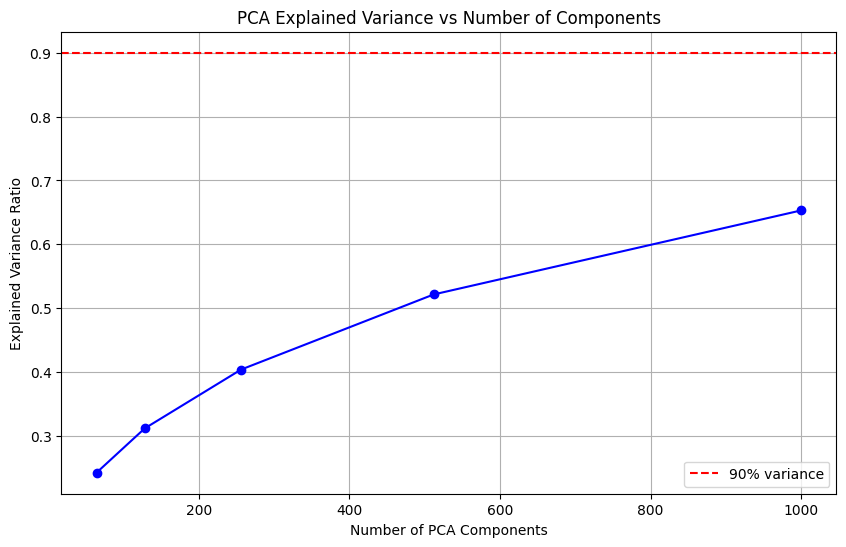

In [1]:
import json
import numpy as np
import torch
import pandas as pd
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print("=== APPLYING PCA TO NODE FEATURES ===\n")

# 1. Load and process features (your existing code)
print("Loading and processing features...")
with open('//kaggle/input/features/deezer_europe_features.json') as f:
    raw_data = json.load(f)

node_ids = sorted(int(k) for k in raw_data.keys())
node_features = {int(k): v for k, v in raw_data.items()}

all_features = [
    [str(f) for f in node_features[nid]]
    for nid in node_ids
]

for i, feats in enumerate(all_features):
    if len(feats) == 0:
        all_features[i] = ['<NO_FEATURE>']

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(all_features)
x = torch.tensor(X, dtype=torch.float)

print(f"Original features shape: {x.shape}")
print(f"Number of nodes: {x.shape[0]}")
print(f"Number of features: {x.shape[1]}")

# 2. Convert to numpy for PCA
X_numpy = x.numpy()
print(f"Converted to numpy: {X_numpy.shape}")

# 3. Apply PCA with different numbers of components
print("\n=== APPLYING PCA ===")

# Option 1: Choose number of components to keep (e.g., 64, 128, 256, 512)
n_components_options = [64, 128, 256, 512, 1000]

# Find the best number of components by explained variance
print("Analyzing explained variance for different component counts...")

pca_results = {}
for n_comp in n_components_options:
    if n_comp < X_numpy.shape[1]:  # Can't have more components than features
        print(f"  Trying {n_comp} components...")
        pca = PCA(n_components=n_comp)
        X_pca = pca.fit_transform(X_numpy)
        explained_var = pca.explained_variance_ratio_.sum()
        
        pca_results[n_comp] = {
            'pca_model': pca,
            'transformed_data': X_pca,
            'explained_variance': explained_var
        }
        
        print(f"    {n_comp} components explain {explained_var:.3f} ({explained_var*100:.1f}%) of variance")

# 4. Choose the best number of components (you can modify this)
# Let's aim for ~90% explained variance or use 256 components (good middle ground)
best_n_components = 256
if best_n_components not in pca_results:
    best_n_components = max(pca_results.keys())

pca_model = pca_results[best_n_components]['pca_model']
X_pca = pca_results[best_n_components]['transformed_data']
explained_var = pca_results[best_n_components]['explained_variance']

print(f"\n✅ Selected {best_n_components} components")
print(f"   Explained variance: {explained_var:.3f} ({explained_var*100:.1f}%)")
print(f"   Reduced from {X_numpy.shape[1]} to {X_pca.shape[1]} features")
print(f"   Compression ratio: {X_numpy.shape[1]/X_pca.shape[1]:.1f}x smaller")

# 5. Create DataFrame with node IDs as index
print("\n=== CREATING DATAFRAME ===")
feature_columns = [f'pca_{i}' for i in range(X_pca.shape[1])]
features_df = pd.DataFrame(X_pca, index=node_ids, columns=feature_columns)

print(f"Features DataFrame shape: {features_df.shape}")
print(f"Node IDs range: {min(node_ids)} to {max(node_ids)}")

# Show sample
print(f"\nSample of PCA features:")
print(features_df.head())

# 6. Save as pickle
print("\n=== SAVING AS PICKLE ===")

# Save just the features DataFrame
features_df.to_pickle('/kaggle/working/node_features_pca.pkl')
print("✅ Saved features as '/kaggle/working/node_features_pca.pkl'")

# Save complete package with metadata
features_package = {
    'features_df': features_df,
    'pca_model': pca_model,
    'node_ids': node_ids,
    'original_shape': X_numpy.shape,
    'pca_shape': X_pca.shape,
    'explained_variance': explained_var,
    'n_components': best_n_components,
    'feature_names': mlb.classes_.tolist(),  # Original feature names
    'metadata': {
        'description': 'PCA-reduced node features from Deezer Europe dataset',
        'original_features': X_numpy.shape[1],
        'pca_components': best_n_components,
        'explained_variance_ratio': explained_var
    }
}

with open('/kaggle/working/node_features_complete.pkl', 'wb') as f:
    pickle.dump(features_package, f)

print("✅ Saved complete package as '/kaggle/working/node_features_complete.pkl'")

# 7. Verification
print("\n=== VERIFICATION ===")
# Test loading
test_df = pd.read_pickle('/kaggle/working/node_features_pca.pkl')
print(f"✅ Verification successful: {test_df.shape}")

# Check specific nodes
sample_nodes = [15, 1777, 19409]
for node in sample_nodes:
    if node in test_df.index:
        features = test_df.loc[node].values
        print(f"Node {node} PCA features: {features[:5]}... (first 5)")

# 8. Usage examples
print("\n=== USAGE EXAMPLES ===")
usage_code = '''
# Load PCA features
features_df = pd.read_pickle('/kaggle/working/node_features_pca.pkl')

# Get features for a node
node_15_features = features_df.loc[15].values

# Combine with embeddings for link prediction
embeddings_df = pd.read_pickle('/kaggle/working/embeddings.pkl')
node_15_embedding = embeddings_df.loc[15].values
node_15_features = features_df.loc[15].values

# Concatenate embedding + features
combined_features = np.concatenate([node_15_embedding, node_15_features])
print(f"Combined shape: {combined_features.shape}")  # e.g., (64+256,) = (320,)
'''

print(usage_code)

print(f"\n🎯 SUMMARY:")
print(f"✅ Reduced features from {X_numpy.shape[1]} to {best_n_components} dimensions")
print(f"✅ Retained {explained_var*100:.1f}% of variance")
print(f"✅ Saved as pickle for fast loading")
print(f"✅ Ready to combine with your Node2Vec embeddings!")

# Optional: Plot explained variance
print(f"\n📊 Creating explained variance plot...")
plt.figure(figsize=(10, 6))
components = list(pca_results.keys())
variances = [pca_results[k]['explained_variance'] for k in components]
plt.plot(components, variances, 'bo-')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance vs Number of Components')
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/pca_explained_variance.png', dpi=300, bbox_inches='tight')
print("✅ Saved variance plot as '/kaggle/working/pca_explained_variance.png'")

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import pickle

print("=== COMPUTING SIMPLE NODE-LEVEL GRAPH FEATURES ===\n")

# Load train edges only (no test edges to avoid leakage!)
train_pos_df = pd.read_csv('/kaggle/input/leakfree-edges/train_positives.csv')
print(f"Loaded {len(train_pos_df)} training edges")

# Create training graph
G_train = nx.from_pandas_edgelist(train_pos_df, 'node_1', 'node_2')
print(f"Training graph: {G_train.number_of_nodes()} nodes, {G_train.number_of_edges()} edges")

# Get all nodes (including isolated test-only nodes)
test_pos_df = pd.read_csv('/kaggle/input/leakfree-edges/test_positives.csv')
train_nodes = set(train_pos_df['node_1']).union(set(train_pos_df['node_2']))
test_nodes = set(test_pos_df['node_1']).union(set(test_pos_df['node_2']))
all_nodes = sorted(train_nodes.union(test_nodes))

# Add isolated nodes to graph
isolated_nodes = test_nodes - train_nodes
G_train.add_nodes_from(isolated_nodes)
print(f"Added {len(isolated_nodes)} isolated nodes")
print(f"Final graph: {G_train.number_of_nodes()} nodes, {G_train.number_of_edges()} edges")

print("\n=== COMPUTING NODE FEATURES ===")

# 1. Basic degree features
print("Computing degree features...")
degrees = dict(G_train.degree())
max_degree = max(degrees.values()) if degrees.values() else 1

degree_features = {}
for node in all_nodes:
    deg = degrees.get(node, 0)
    degree_features[node] = {
        'degree': deg,
        'degree_normalized': deg / max_degree if max_degree > 0 else 0.0
    }

print(f"✅ Degree features computed")

# 2. Local clustering
print("Computing clustering coefficient...")
clustering = nx.clustering(G_train)
print(f"✅ Clustering coefficient computed")

# 3. Triangle count
print("Computing triangle counts...")
triangles = nx.triangles(G_train)
print(f"✅ Triangle counts computed")

# 4. PageRank (works even with isolated nodes)
print("Computing PageRank...")
pagerank = nx.pagerank(G_train, alpha=0.85)
print(f"✅ PageRank computed")

# 5. Degree centrality
print("Computing degree centrality...")
degree_centrality = nx.degree_centrality(G_train)
print(f"✅ Degree centrality computed")

# 6. Simple neighborhood features
print("Computing neighborhood features...")
neighborhood_features = {}
for node in all_nodes:
    neighbors = list(G_train.neighbors(node)) if node in G_train else []
    
    # Neighbor degrees
    neighbor_degrees = [degrees.get(n, 0) for n in neighbors]
    
    neighborhood_features[node] = {
        'num_neighbors': len(neighbors),
        'avg_neighbor_degree': np.mean(neighbor_degrees) if neighbor_degrees else 0.0,
        'max_neighbor_degree': max(neighbor_degrees) if neighbor_degrees else 0,
        'min_neighbor_degree': min(neighbor_degrees) if neighbor_degrees else 0
    }

print(f"✅ Neighborhood features computed")

print("\n=== COMPILING ALL FEATURES ===")

# Combine all features into one DataFrame
all_features = []
feature_names = [
    'degree', 'degree_normalized', 'clustering', 'triangles', 
    'pagerank', 'degree_centrality', 'num_neighbors',
    'avg_neighbor_degree', 'max_neighbor_degree', 'min_neighbor_degree'
]

for node in all_nodes:
    node_features = [
        degree_features[node]['degree'],
        degree_features[node]['degree_normalized'],
        clustering.get(node, 0.0),
        triangles.get(node, 0),
        pagerank.get(node, 0.0),
        degree_centrality.get(node, 0.0),
        neighborhood_features[node]['num_neighbors'],
        neighborhood_features[node]['avg_neighbor_degree'],
        neighborhood_features[node]['max_neighbor_degree'],
        neighborhood_features[node]['min_neighbor_degree']
    ]
    all_features.append(node_features)

# Create DataFrame
graph_features_df = pd.DataFrame(
    all_features,
    index=all_nodes,
    columns=feature_names
)

print(f"Graph features shape: {graph_features_df.shape}")
print(f"Feature names: {feature_names}")

print("\nSample of graph features:")
print(graph_features_df.head(10))

print("\nFeature statistics:")
print(graph_features_df.describe())

# Check isolated nodes specifically
print(f"\nIsolated nodes sample (first 5):")
isolated_sample = sorted(list(isolated_nodes))[:5]
if isolated_sample:
    print(graph_features_df.loc[isolated_sample])
    print("(Note: isolated nodes should have mostly zeros)")

print("\n=== SAVING FEATURES ===")

# Save as pickle
graph_features_df.to_pickle('/kaggle/working/simple_graph_features.pkl')
print("✅ Saved as '/kaggle/working/simple_graph_features.pkl'")

# Save complete package
simple_package = {
    'features_df': graph_features_df,
    'feature_names': feature_names,
    'metadata': {
        'description': 'Simple per-node graph features from training graph only',
        'num_nodes': len(all_nodes),
        'num_features': len(feature_names),
        'isolated_nodes_count': len(isolated_nodes),
        'no_data_leakage': True
    }
}

with open('/kaggle/working/simple_graph_features_complete.pkl', 'wb') as f:
    pickle.dump(simple_package, f)

print("✅ Saved complete package as '/kaggle/working/simple_graph_features_complete.pkl'")




print(f"\n🎯 SUMMARY:")
print(f"✅ Computed 10 simple graph features per node")
print(f"✅ Features: degree, clustering, PageRank, neighborhood stats")
print(f"✅ No data leakage - computed from training graph only")
print(f"✅ Isolated nodes handled gracefully (get zero/default values)")
print(f"✅ Ready to combine with embeddings and PCA features")
print(f"✅ Total feature vector per node: 64 + 256 + 10 = 330 dimensions")

=== COMPUTING SIMPLE NODE-LEVEL GRAPH FEATURES ===

Loaded 74201 training edges
Training graph: 26895 nodes, 74201 edges
Added 1386 isolated nodes
Final graph: 28281 nodes, 74201 edges

=== COMPUTING NODE FEATURES ===
Computing degree features...
✅ Degree features computed
Computing clustering coefficient...
✅ Clustering coefficient computed
Computing triangle counts...
✅ Triangle counts computed
Computing PageRank...
✅ PageRank computed
Computing degree centrality...
✅ Degree centrality computed
Computing neighborhood features...
✅ Neighborhood features computed

=== COMPILING ALL FEATURES ===
Graph features shape: (28281, 10)
Feature names: ['degree', 'degree_normalized', 'clustering', 'triangles', 'pagerank', 'degree_centrality', 'num_neighbors', 'avg_neighbor_degree', 'max_neighbor_degree', 'min_neighbor_degree']

Sample of graph features:
   degree  degree_normalized  clustering  triangles  pagerank  \
0       7           0.054264    0.142857          3  0.000042   
1      69     